Marco de Luca   - ENSIIE ERASMUS-M2QF
Jacopo Spandri  - ENSIIE ERASMUS-M2QF


TP5 - MAL PROJECT

LOADING LIBRARIES

In [1]:
!pip install -r requirements.txt 

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from numpy import quantile

from sklearn.model_selection import (
    train_test_split,
    StratifiedKFold,
    cross_val_score,
    RandomizedSearchCV,
)
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import (
    IsolationForest,
    BaggingClassifier,
    RandomForestClassifier,
    ExtraTreesClassifier,
    AdaBoostClassifier,
    GradientBoostingClassifier,
    StackingClassifier,
)
from sklearn.neighbors import LocalOutlierFactor, KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import (
    LinearDiscriminantAnalysis,
    QuadraticDiscriminantAnalysis,
)
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    roc_curve,
    auc,
    classification_report,
    confusion_matrix,
)
from scipy.stats import randint, uniform
from sklearn.model_selection import RandomizedSearchCV
from itertools import combinations
from sklearn.metrics import confusion_matrix

DATA LOADING AND PREPROCESSING

In [3]:
df = pd.read_csv("celldata.csv")
print(df.head())
print(df.info())
print(df.describe())

print(df.describe().loc[["min", "max"]])
print(df.isnull().sum())

print(df["Geography"].unique())
print(df["Gender"].unique())

# define features and target
y = df["Churn"]
X = df.drop(columns=["Churn"])

# encoding categorical variables
X["Gender"] = X["Gender"].map({"Female": 0, "Male": 1})
X = pd.get_dummies(X, columns=["Geography"], drop_first=True)

print(X.head())
print(X.info())
print(y.value_counts())

   CreditScore Geography  Gender  Age  Tenure    Balance  NumOfProducts  \
0          632   Germany  Female   50       5  107959.39              1   
1          649    France  Female   42       7       0.00              2   
2          595    France    Male   29       6  150685.79              1   
3          653     Spain    Male   35       6  116662.96              2   
4          559     Spain  Female   40       7  144470.77              1   

   HasCrCard  IsActiveMember  Salary  Churn  
0          1               1    6985      1  
1          0               1   22974      0  
2          1               0   87771      0  
3          1               1   23864      0  
4          1               1   18918      0  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8000 entries, 0 to 7999
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   CreditScore     8000 non-null   int64  
 1   Geography       8000 non-n

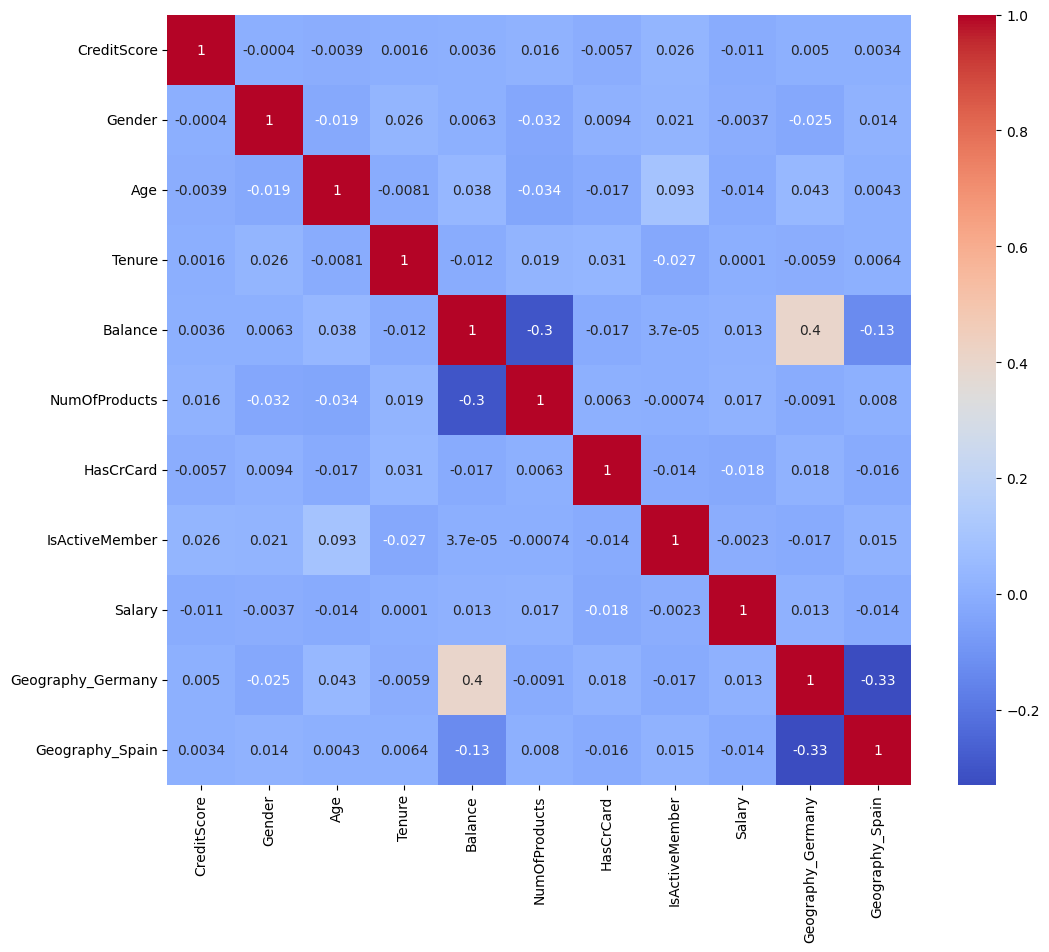

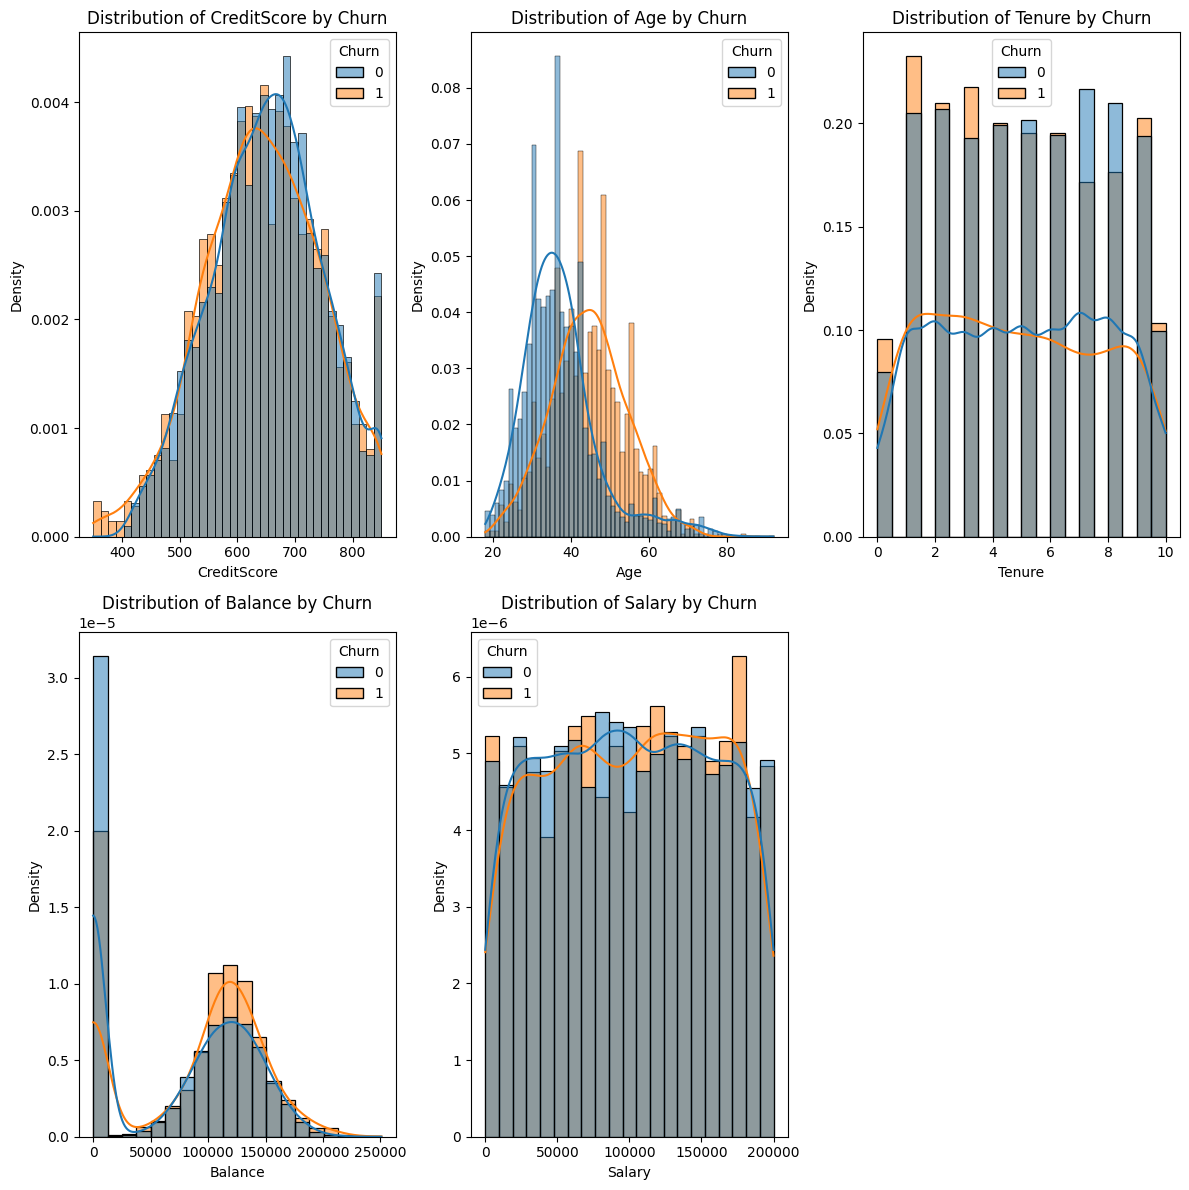

In [4]:
# correlation matrix
corr = X.corr()
plt.figure(figsize=(12, 10))
sns.heatmap(corr, annot=True, cmap="coolwarm")
plt.show()

# Plot all distributions together
fig, axes = plt.subplots(2, 3, figsize=(12, 12))
axes = axes.flatten()

for idx, col in enumerate(["CreditScore", "Age", "Tenure", "Balance", "Salary"]):
    sns.histplot(
        data=df,
        x=col,
        hue="Churn",
        kde=True,
        stat="density",
        common_norm=False,
        ax=axes[idx]
    )
    axes[idx].set_title(f"Distribution of {col} by Churn")

axes[-1].remove()  # Remove the extra subplot
plt.tight_layout()
plt.show()

In [5]:
# split into train and test with stratification to preserve class distribution
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# standardize features for models requiring it
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


# sample weights to handle class imbalance
classes = np.unique(y_train)
class_counts = np.bincount(y_train)
class_weights = {cls: len(y_train) / (len(classes) * class_counts[cls]) 
                 for cls in classes}
sample_weight = np.array([class_weights[y] for y in y_train])

MODELS FITTING

FIXED PARAMETERS CV

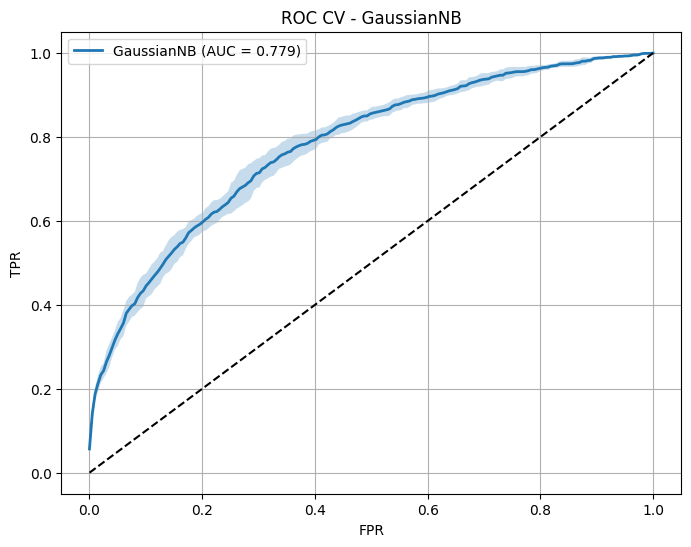


Classification Report - GaussianNB
              precision    recall  f1-score   support

           0       0.90      0.74      0.81      5113
           1       0.39      0.67      0.49      1287

    accuracy                           0.72      6400
   macro avg       0.64      0.70      0.65      6400
weighted avg       0.80      0.72      0.75      6400

Confusion Matrix:
[[3765 1348]
 [ 425  862]]


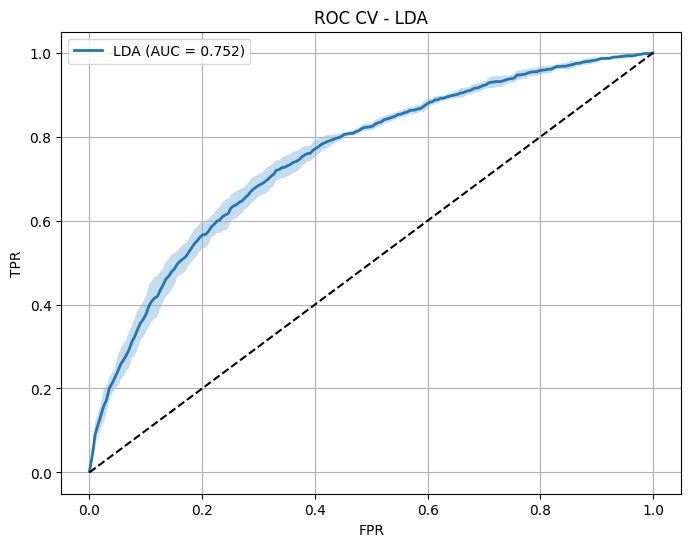


Classification Report - LDA
              precision    recall  f1-score   support

           0       0.83      0.96      0.89      5113
           1       0.58      0.21      0.31      1287

    accuracy                           0.81      6400
   macro avg       0.70      0.59      0.60      6400
weighted avg       0.78      0.81      0.77      6400

Confusion Matrix:
[[4920  193]
 [1019  268]]


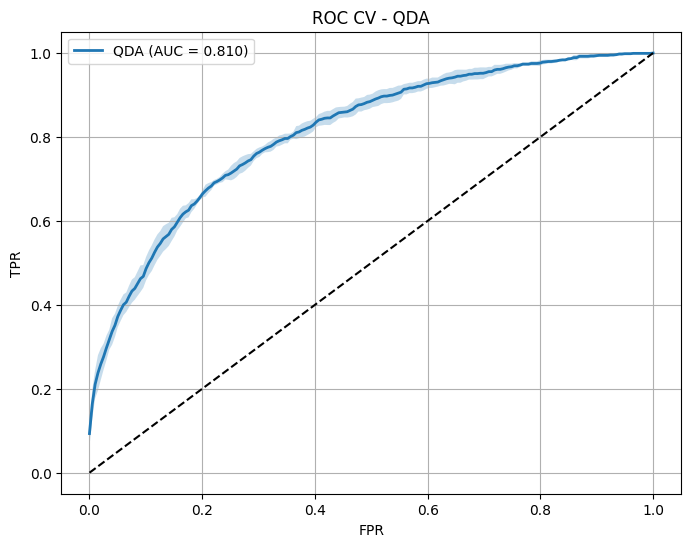


Classification Report - QDA
              precision    recall  f1-score   support

           0       0.86      0.95      0.90      5113
           1       0.66      0.36      0.47      1287

    accuracy                           0.83      6400
   macro avg       0.76      0.66      0.69      6400
weighted avg       0.82      0.83      0.82      6400

Confusion Matrix:
[[4877  236]
 [ 821  466]]


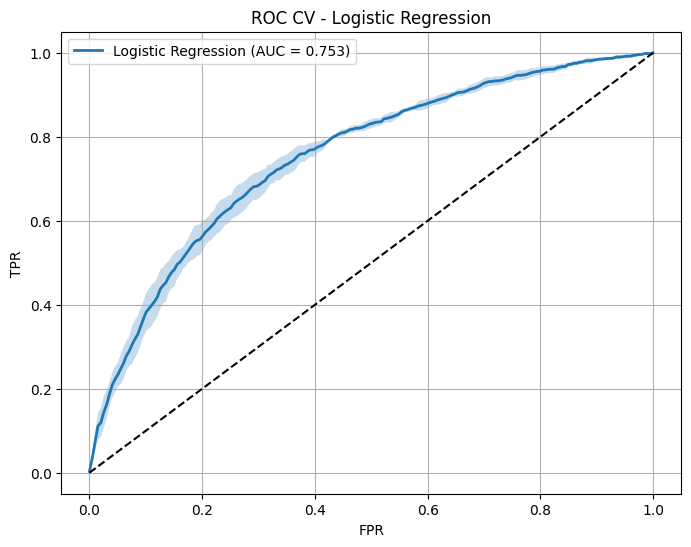


Classification Report - Logistic Regression
              precision    recall  f1-score   support

           0       0.90      0.70      0.79      5113
           1       0.37      0.68      0.48      1287

    accuracy                           0.70      6400
   macro avg       0.63      0.69      0.63      6400
weighted avg       0.79      0.70      0.73      6400

Confusion Matrix:
[[3595 1518]
 [ 408  879]]


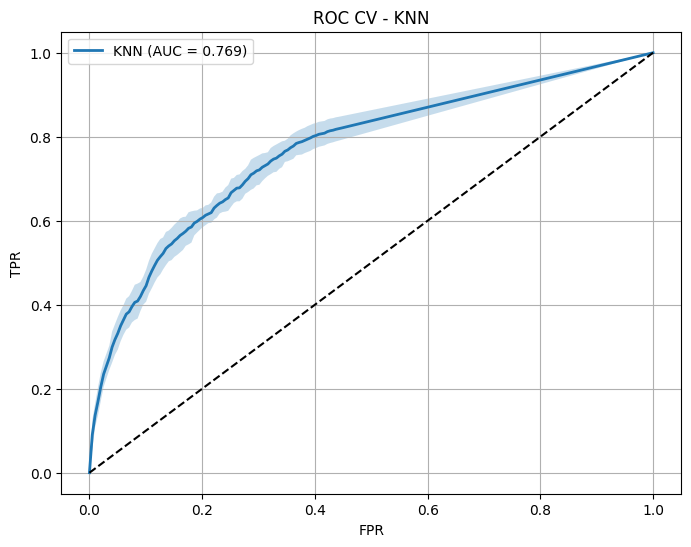


Classification Report - KNN
              precision    recall  f1-score   support

           0       0.85      0.94      0.90      5113
           1       0.61      0.35      0.45      1287

    accuracy                           0.82      6400
   macro avg       0.73      0.65      0.67      6400
weighted avg       0.80      0.82      0.81      6400

Confusion Matrix:
[[4828  285]
 [ 835  452]]


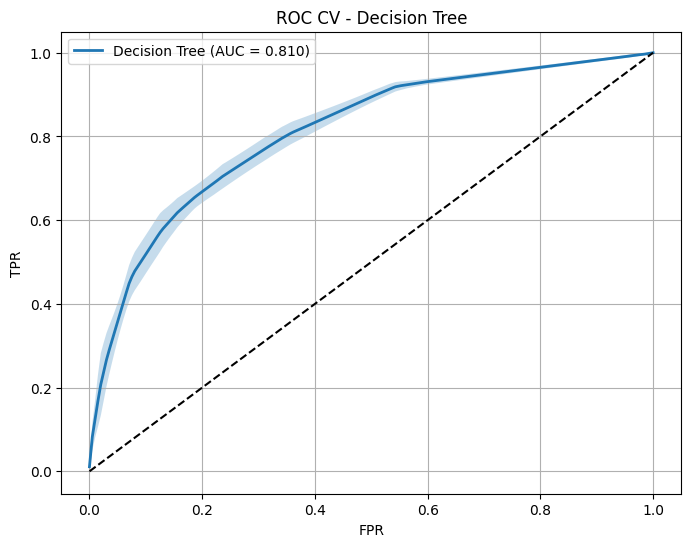


Classification Report - Decision Tree
              precision    recall  f1-score   support

           0       0.92      0.72      0.81      5113
           1       0.40      0.75      0.52      1287

    accuracy                           0.73      6400
   macro avg       0.66      0.73      0.67      6400
weighted avg       0.82      0.73      0.75      6400

Confusion Matrix:
[[3678 1435]
 [ 322  965]]


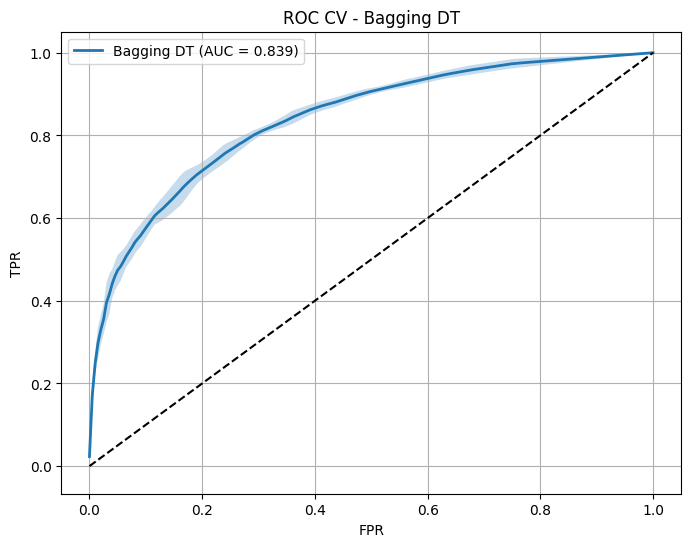


Classification Report - Bagging DT
              precision    recall  f1-score   support

           0       0.87      0.96      0.91      5113
           1       0.74      0.43      0.54      1287

    accuracy                           0.85      6400
   macro avg       0.80      0.70      0.73      6400
weighted avg       0.84      0.85      0.84      6400

Confusion Matrix:
[[4915  198]
 [ 734  553]]


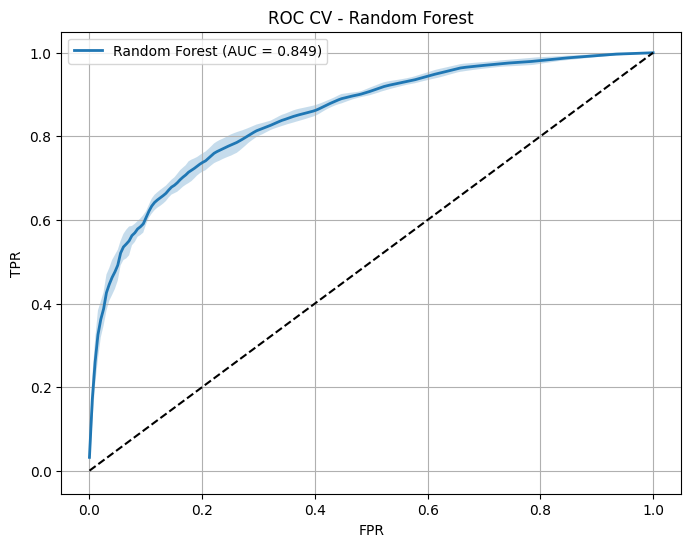


Classification Report - Random Forest
              precision    recall  f1-score   support

           0       0.87      0.97      0.92      5113
           1       0.77      0.42      0.55      1287

    accuracy                           0.86      6400
   macro avg       0.82      0.70      0.73      6400
weighted avg       0.85      0.86      0.84      6400

Confusion Matrix:
[[4955  158]
 [ 745  542]]


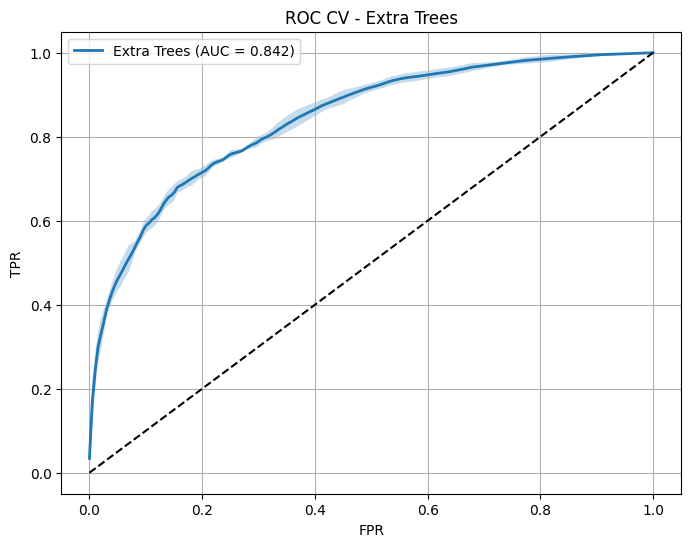


Classification Report - Extra Trees
              precision    recall  f1-score   support

           0       0.87      0.96      0.91      5113
           1       0.75      0.42      0.54      1287

    accuracy                           0.85      6400
   macro avg       0.81      0.69      0.72      6400
weighted avg       0.84      0.85      0.84      6400

Confusion Matrix:
[[4930  183]
 [ 750  537]]


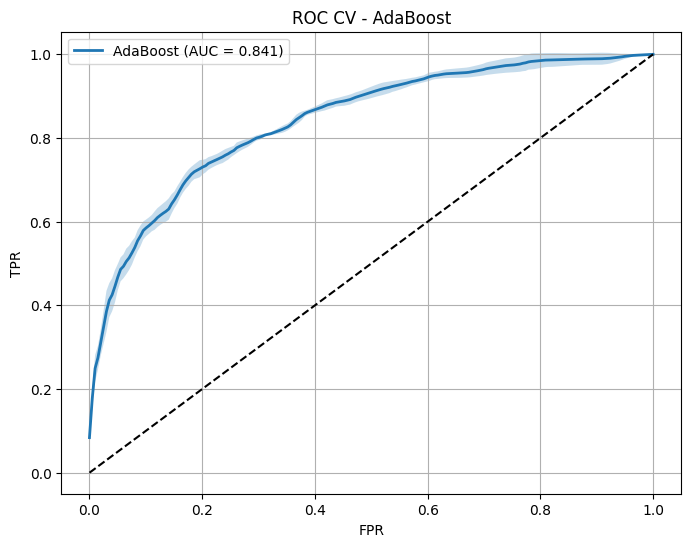


Classification Report - AdaBoost
              precision    recall  f1-score   support

           0       0.92      0.81      0.86      5113
           1       0.48      0.73      0.58      1287

    accuracy                           0.79      6400
   macro avg       0.70      0.77      0.72      6400
weighted avg       0.83      0.79      0.80      6400

Confusion Matrix:
[[4120  993]
 [ 353  934]]


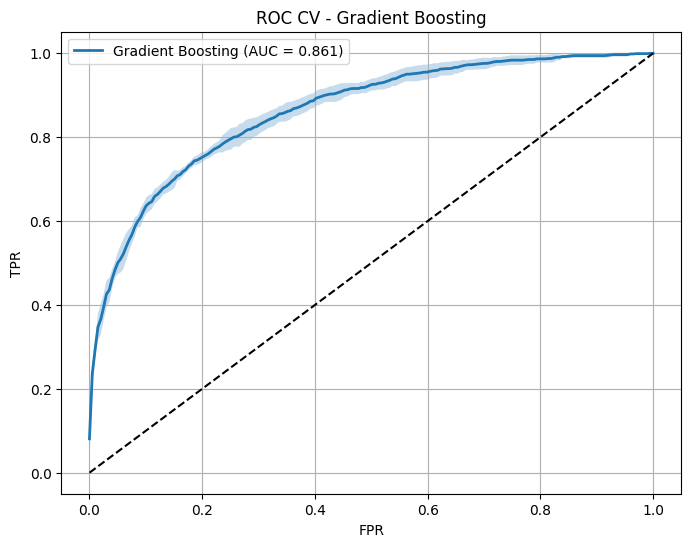


Classification Report - Gradient Boosting
              precision    recall  f1-score   support

           0       0.92      0.82      0.87      5113
           1       0.50      0.73      0.60      1287

    accuracy                           0.80      6400
   macro avg       0.71      0.78      0.73      6400
weighted avg       0.84      0.80      0.81      6400

Confusion Matrix:
[[4187  926]
 [ 345  942]]


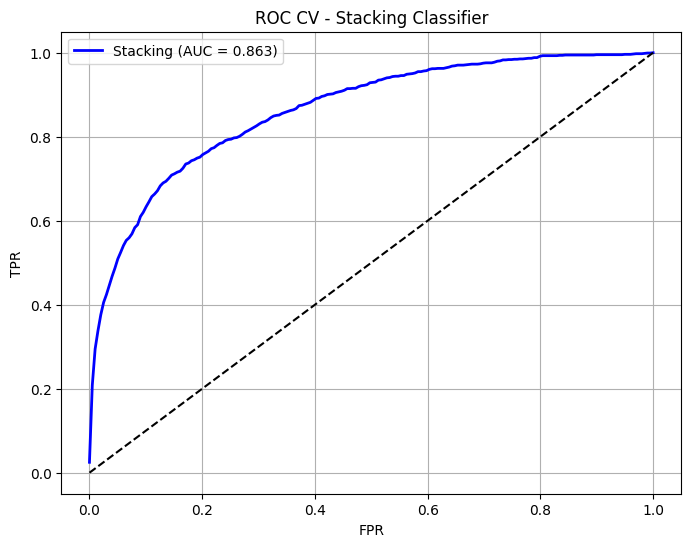


Classification Report - Stacking
Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.91      0.90      5113
           1       0.62      0.60      0.61      1287

    accuracy                           0.84      6400
   macro avg       0.76      0.75      0.76      6400
weighted avg       0.84      0.84      0.84      6400

Confusion Matrix:
[[4638  475]
 [ 518  769]]
                  Model  CV-Accuracy  CV-Precision  CV-Recall     CV-F1  \
11             Stacking     0.844844      0.618167   0.597514  0.607665   
10    Gradient Boosting     0.801406      0.504879   0.731961  0.597197   
7         Random Forest     0.858906      0.775456   0.421196  0.544831   
9              AdaBoost     0.789687      0.485334   0.725732  0.581443   
8           Extra Trees     0.854219      0.746511   0.417290  0.534561   
6            Bagging DT     0.854375      0.737695   0.429717  0.542323   
2                   QDA     0.834844      0.66

/var/folders/mq/vjflf4v17wv_rvtlxmrx4rrc0000gn/T/ipykernel_3893/1906908561.py:245: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('tab20', len(all_roc_curves))


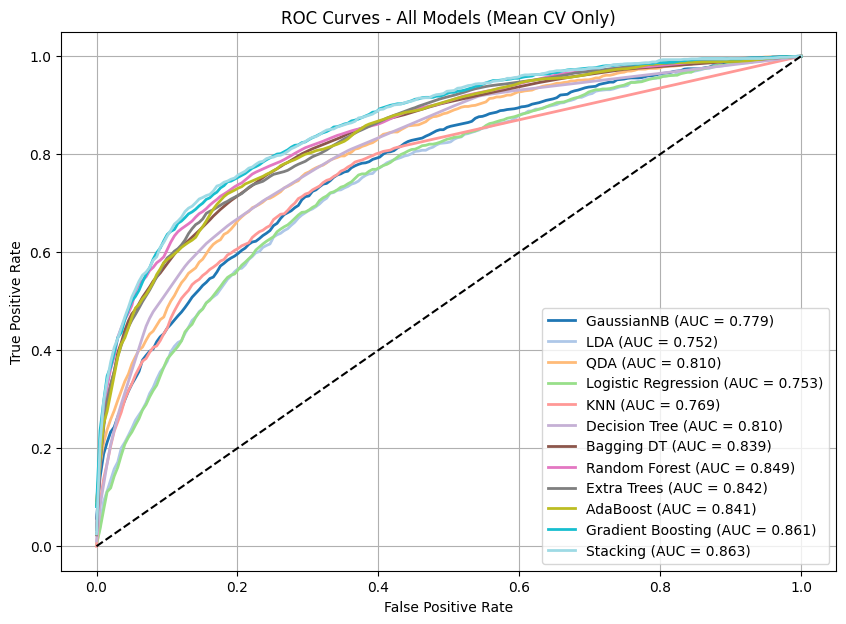

In [6]:
models = {
    "GaussianNB": (GaussianNB(), "scaled"),
    "LDA": (LinearDiscriminantAnalysis(n_components=1), "scaled"),
    "QDA": (QuadraticDiscriminantAnalysis(), "scaled"),
    "Logistic Regression": (LogisticRegression(class_weight="balanced"), "scaled"),
    "KNN": (KNeighborsClassifier(n_neighbors=5, weights="distance"), "scaled"),
    "Decision Tree": (DecisionTreeClassifier(
        criterion="gini", max_depth=20, max_leaf_nodes=10,
        class_weight="balanced", random_state=42
    ), "raw"),
    "Bagging DT": (BaggingClassifier(
        estimator=DecisionTreeClassifier(criterion="gini", class_weight="balanced", random_state=42),
        n_estimators=50, random_state=42
    ), "raw"),
    "Random Forest": (RandomForestClassifier(class_weight="balanced", random_state=42), "raw"),
    "Extra Trees": (ExtraTreesClassifier(class_weight="balanced", random_state=42), "raw"),
    "AdaBoost": (AdaBoostClassifier(n_estimators=100, random_state=42), "raw"),
    "Gradient Boosting": (GradientBoostingClassifier(n_estimators=100, random_state=42), "raw")
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

def compute_cv(model, X, y):
    accs, precs, recs, f1s, aucs = [], [], [], [], []
    mean_fpr = np.linspace(0, 1, 200)
    tprs = []
    oof_preds = np.zeros(len(y))

    for train_idx, val_idx in cv.split(X, y):
        X_tr = X[train_idx] if isinstance(X, np.ndarray) else X.iloc[train_idx]
        X_val = X[val_idx] if isinstance(X, np.ndarray) else X.iloc[val_idx]
        y_tr = y[train_idx] if isinstance(y, np.ndarray) else y.iloc[train_idx]
        y_val = y[val_idx] if isinstance(y, np.ndarray) else y.iloc[val_idx]

        sw_tr = None
        if "sample_weight" in globals():
            sw = sample_weight
            sw_tr = sw[train_idx] if isinstance(sw, np.ndarray) else sw.iloc[train_idx]

        if isinstance(model, (GaussianNB, AdaBoostClassifier, GradientBoostingClassifier)):
            model.fit(X_tr, y_tr, sample_weight=sw_tr) if sw_tr is not None else model.fit(X_tr, y_tr)
        else:
            model.fit(X_tr, y_tr)

        y_pred_val = model.predict(X_val)
        y_prob_val = model.predict_proba(X_val)[:, 1]

        accs.append(accuracy_score(y_val, y_pred_val))
        precs.append(precision_score(y_val, y_pred_val))
        recs.append(recall_score(y_val, y_pred_val))
        f1s.append(f1_score(y_val, y_pred_val))
        aucs.append(roc_auc_score(y_val, y_prob_val))

        oof_preds[val_idx] = y_pred_val

        fpr, tpr, _ = roc_curve(y_val, y_prob_val)
        tpr_interp = np.interp(mean_fpr, fpr, tpr)
        tprs.append(tpr_interp)

    tprs = np.array(tprs)
    mean_tpr = tprs.mean(axis=0)
    std_tpr = tprs.std(axis=0)

    return {
        "acc": np.mean(accs),
        "prec": np.mean(precs),
        "rec": np.mean(recs),
        "f1": np.mean(f1s),
        "auc": np.mean(aucs),
        "mean_fpr": mean_fpr,
        "mean_tpr": mean_tpr,
        "std_tpr": std_tpr,
        "oof_preds": oof_preds
    }

results = []

all_roc_curves = []

for name, (model, dtype) in models.items():
    X_input = X_train_scaled if dtype == "scaled" else X_train
    res = compute_cv(model, X_input, y_train)
    all_roc_curves.append((name, res["mean_fpr"], res["mean_tpr"], res["auc"]))

    plt.figure(figsize=(8,6))
    plt.plot(res["mean_fpr"], res["mean_tpr"], linewidth=2, label=f"{name} (AUC = {res['auc']:.3f})")
    plt.fill_between(res["mean_fpr"], res["mean_tpr"] - res["std_tpr"], res["mean_tpr"] + res["std_tpr"], alpha=0.25)
    plt.plot([0,1],[0,1],"k--")
    plt.title("ROC CV - " + name)
    plt.xlabel("FPR")
    plt.ylabel("TPR")
    plt.legend()
    plt.grid()
    plt.show()

    print(f"\nClassification Report - {name}")
    print(classification_report(y_train, res["oof_preds"]))
    print("Confusion Matrix:")
    print(confusion_matrix(y_train, res["oof_preds"]))

    X_test_input = X_test_scaled if dtype == "scaled" else X_test
    sw_tr = sample_weight if "sample_weight" in globals() else None
    if isinstance(model, (GaussianNB, AdaBoostClassifier, GradientBoostingClassifier)):
        model.fit(X_input, y_train, sample_weight=sw_tr) if sw_tr is not None else model.fit(X_input, y_train)
    else:
        model.fit(X_input, y_train)
    y_pred_test = model.predict(X_test_input)
    y_prob_test = model.predict_proba(X_test_input)[:, 1]

    results.append([
        name,
        res["acc"],
        res["prec"],
        res["rec"],
        res["f1"],
        res["auc"],
        accuracy_score(y_test, y_pred_test),
        precision_score(y_test, y_pred_test),
        recall_score(y_test, y_pred_test),
        f1_score(y_test, y_pred_test),
        roc_auc_score(y_test, y_prob_test)
    ])



estimators = [
    ("lr", LogisticRegression(class_weight="balanced"), "scaled"),
    ("rf", RandomForestClassifier(class_weight="balanced", random_state=42), "raw"),
    ("gb", GradientBoostingClassifier(n_estimators=100, random_state=42), "raw"),
    ("nb", GaussianNB(), "scaled"),
    ("et", ExtraTreesClassifier(class_weight="balanced", random_state=42), "raw")
]

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
meta_train = np.zeros((X_train.shape[0], len(estimators)))
meta_test = np.zeros((X_test.shape[0], len(estimators)))
oof_preds_total = np.zeros(X_train.shape[0])

tprs = []
mean_fpr = np.linspace(0, 1, 200)

for i, (name, model, dtype) in enumerate(estimators):
    X_input = X_train_scaled if dtype == "scaled" else X_train
    test_input = X_test_scaled if dtype == "scaled" else X_test
    
    oof_preds = np.zeros(X_input.shape[0])
    test_preds_folds = np.zeros((X_test.shape[0], cv.n_splits))
    
    for fold_idx, (train_idx, val_idx) in enumerate(cv.split(X_input, y_train)):
        if isinstance(X_input, np.ndarray):
            X_tr, X_val = X_input[train_idx], X_input[val_idx]
        else:
            X_tr, X_val = X_input.iloc[train_idx], X_input.iloc[val_idx]
        
        if isinstance(y_train, np.ndarray):
            y_tr, y_val = y_train[train_idx], y_train[val_idx]
        else:
            y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]

        sw_tr = None
        if "sample_weight" in globals() and isinstance(model, (GaussianNB, AdaBoostClassifier, GradientBoostingClassifier)):
            sw_tr = sample_weight[train_idx] if isinstance(sample_weight, np.ndarray) else sample_weight.iloc[train_idx]

        if sw_tr is not None:
            model.fit(X_tr, y_tr, sample_weight=sw_tr)
        else:
            model.fit(X_tr, y_tr)
        
        oof_preds[val_idx] = model.predict_proba(X_val)[:, 1]
        test_preds_folds[:, fold_idx] = model.predict_proba(test_input)[:, 1]
    
    meta_train[:, i] = oof_preds
    meta_test[:, i] = test_preds_folds.mean(axis=1)
    oof_preds_total += oof_preds 

final_est = LogisticRegression(class_weight="balanced", max_iter=1000)
final_est.fit(meta_train, y_train)

y_pred_cv_stack = (meta_train.mean(axis=1) > 0.5).astype(int)
y_prob_cv_stack = final_est.predict_proba(meta_train)[:, 1]

acc_cv = accuracy_score(y_train, y_pred_cv_stack)
prec_cv = precision_score(y_train, y_pred_cv_stack)
rec_cv = recall_score(y_train, y_pred_cv_stack)
f1_cv = f1_score(y_train, y_pred_cv_stack)
roc_auc_cv = roc_auc_score(y_train, y_prob_cv_stack)

fpr, tpr, _ = roc_curve(y_train, y_prob_cv_stack)
tpr_interp = np.interp(mean_fpr, fpr, tpr)
tprs.append(tpr_interp)
mean_tpr = np.mean(tprs, axis=0)
std_tpr = np.std(tprs, axis=0)
all_roc_curves.append(("Stacking", mean_fpr, mean_tpr, roc_auc_cv))

plt.figure(figsize=(8,6))
plt.plot(mean_fpr, mean_tpr, linewidth=2, label=f"Stacking (AUC = {roc_auc_cv:.3f})", color="blue")
plt.fill_between(mean_fpr, mean_tpr - std_tpr, mean_tpr + std_tpr, alpha=0.25)
plt.plot([0,1],[0,1],"k--")
plt.title("ROC CV - Stacking Classifier")
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.legend()
plt.grid()
plt.show()

print("\nClassification Report - Stacking")
print("Classification Report:")
print(classification_report(y_train, y_pred_cv_stack))
print("Confusion Matrix:")
print(confusion_matrix(y_train, y_pred_cv_stack))

y_pred_test_stack = final_est.predict(meta_test)
y_prob_test_stack = final_est.predict_proba(meta_test)[:, 1]

acc_test = accuracy_score(y_test, y_pred_test_stack)
prec_test = precision_score(y_test, y_pred_test_stack)
rec_test = recall_score(y_test, y_pred_test_stack)
f1_test = f1_score(y_test, y_pred_test_stack)
roc_auc_test = roc_auc_score(y_test, y_prob_test_stack)

results.append([
    "Stacking",
    acc_cv, prec_cv, rec_cv, f1_cv, roc_auc_cv,
    acc_test, prec_test, rec_test, f1_test, roc_auc_test
])



summary_df = pd.DataFrame(
    results,
    columns=[
        "Model","CV-Accuracy","CV-Precision","CV-Recall","CV-F1","CV-ROC-AUC",
        "Test-Accuracy","Test-Precision","Test-Recall","Test-F1","Test-ROC-AUC"
    ]
)

print(summary_df.sort_values("Test-ROC-AUC", ascending=False))


import matplotlib.pyplot as plt
import matplotlib.cm as cm

plt.figure(figsize=(10, 7))

cmap = cm.get_cmap('tab20', len(all_roc_curves))

for i, (name, fpr, tpr, auc) in enumerate(all_roc_curves):
    plt.plot(fpr, tpr, linewidth=2, color=cmap(i),
             label=f"{name} (AUC = {auc:.3f})")

plt.plot([0, 1], [0, 1], "k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves - All Models (Mean CV Only)")
plt.grid()
plt.legend()
plt.show()


HYPERPARAMETERS TUNING CV

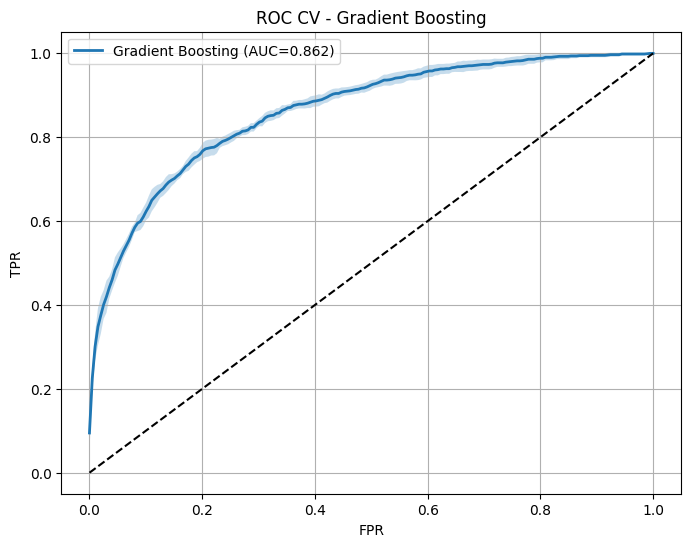

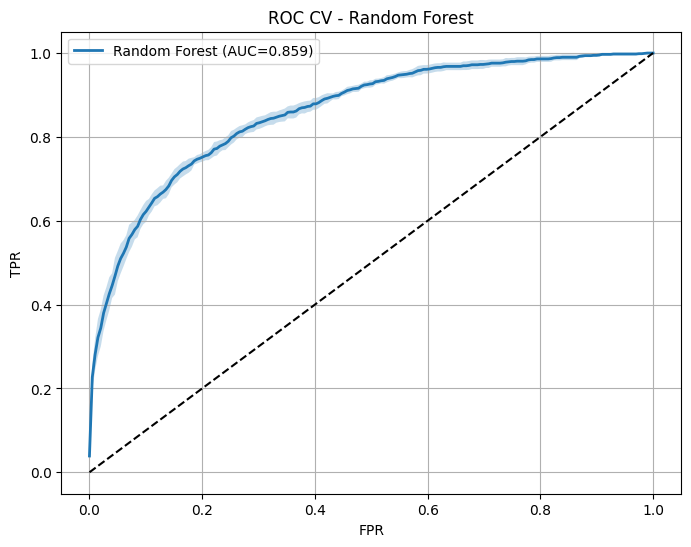

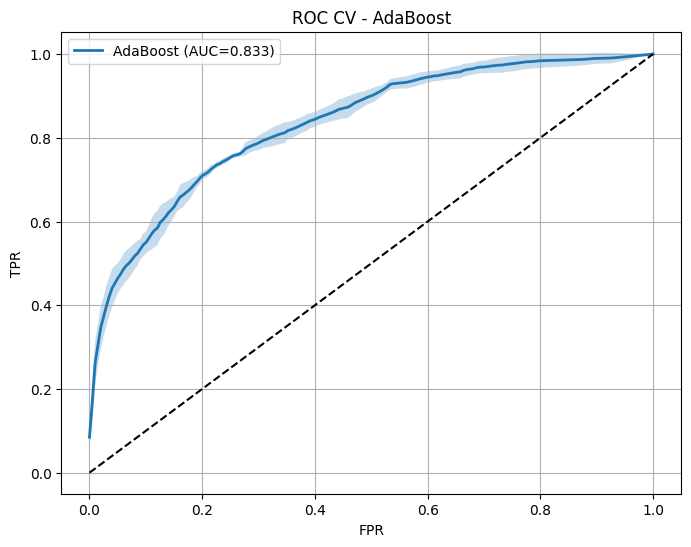

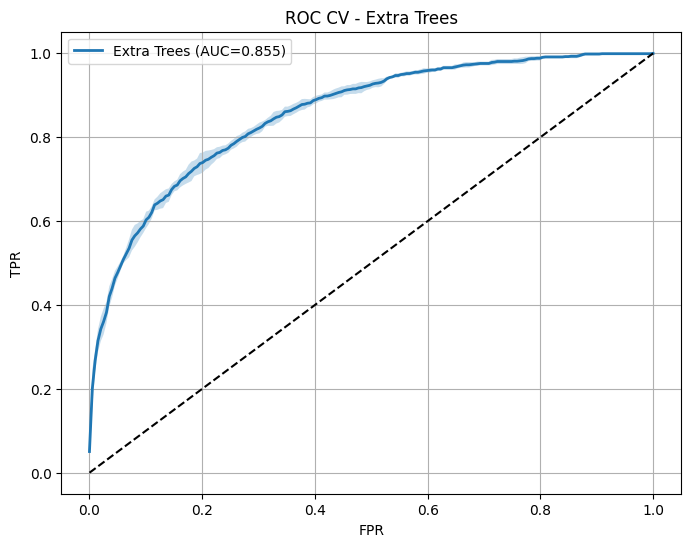

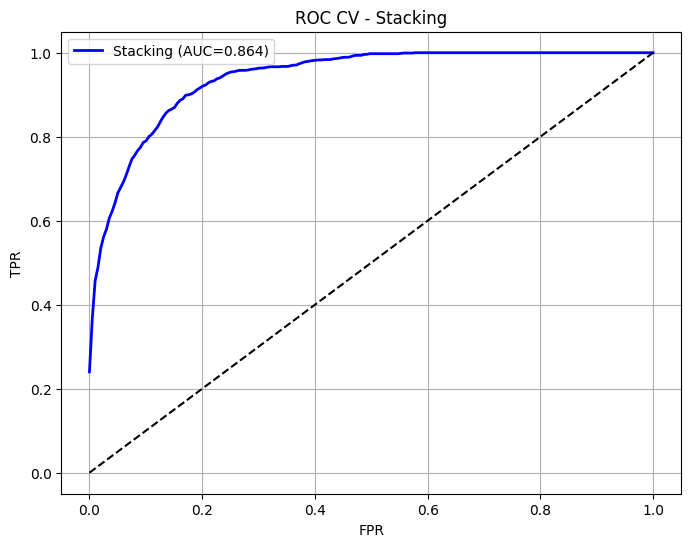

               Model  CV-Accuracy  CV-Precision  CV-Recall     CV-F1  \
0  Gradient Boosting     0.811875      0.523197   0.727273  0.608583   
4           Stacking     0.872500      0.646338   0.811996  0.719382   
1      Random Forest     0.827031      0.558442   0.668221  0.608419   
3        Extra Trees     0.825937      0.557628   0.650350  0.600430   
2           AdaBoost     0.786719      0.479189   0.697747  0.568175   

   CV-ROC-AUC  Test-Accuracy  Test-Precision  Test-Recall   Test-F1  \
0    0.861631       0.817500        0.533632     0.739130  0.619792   
4    0.863591       0.825000        0.551471     0.698758  0.616438   
1    0.858600       0.833750        0.575269     0.664596  0.616715   
3    0.855203       0.828125        0.564033     0.642857  0.600871   
2    0.833235       0.797500        0.497817     0.708075  0.584615   

   Test-ROC-AUC  
0      0.864161  
4      0.861522  
1      0.855952  
3      0.848801  
2      0.835067  


In [7]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

estimators_to_tune = {
    "Gradient Boosting": (GradientBoostingClassifier(random_state=42), {
    "n_estimators": randint(50, 200),          
    "learning_rate": uniform(0.01, 0.1),     
    "max_depth": randint(2, 5),            
    "subsample": uniform(0.7, 0.3),           
    "min_samples_split": randint(5, 21),     
    "min_samples_leaf": randint(3, 11),      
    "max_features": ["sqrt", "log2"],      
    }),

    "Random Forest": (RandomForestClassifier(random_state=42), {
    "n_estimators": randint(100, 300),      
    "max_depth": [None]+list(range(3,30)),   
    "min_samples_split": randint(2,21),
    "min_samples_leaf": randint(1,15),
    "max_features": ["sqrt","log2"],        
    "class_weight": [None, "balanced"],            
    "bootstrap": [True],
    }),

    "AdaBoost": (AdaBoostClassifier(random_state=42), {
    "n_estimators": randint(50,200),
    "learning_rate": uniform(0.01,0.2), 
    }),

    "Extra Trees": (ExtraTreesClassifier(random_state=42, n_jobs=-1), {
    "n_estimators": randint(100,300),
    "max_depth": [None]+list(range(3,30)),
    "min_samples_split": randint(2,21),
    "min_samples_leaf": randint(1,15),
    "max_features": ["sqrt","log2"],
    "class_weight": [None, "balanced"],
    "bootstrap": [True],
    }),
}

tuned_estimators = {}
cv_results_base = []

for name, (model, params) in estimators_to_tune.items():
    search = RandomizedSearchCV(
        estimator=model,
        param_distributions=params,
        n_iter=40,
        scoring="roc_auc",
        cv=cv,
        random_state=42,
        n_jobs=-1
    )
    try:
        search.fit(X_train, y_train, sample_weight=sample_weight)
    except TypeError:
        search.fit(X_train, y_train)
    best_model = search.best_estimator_
    tuned_estimators[name] = best_model
    y_pred_cv = np.zeros(y_train.shape)
    tprs = []
    mean_fpr = np.linspace(0,1,200)
    for train_idx, val_idx in cv.split(X_train, y_train):
        X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
        y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]
        try:
            best_model.fit(X_tr, y_tr, sample_weight=sample_weight[train_idx])
        except TypeError:
            best_model.fit(X_tr, y_tr)
        y_pred = best_model.predict(X_val)
        y_prob = best_model.predict_proba(X_val)[:,1]
        y_pred_cv[val_idx] = y_prob
        fpr, tpr, _ = roc_curve(y_val, y_prob)
        tpr_interp = np.interp(mean_fpr, fpr, tpr)
        tprs.append(tpr_interp)
    tprs = np.array(tprs)
    mean_tpr = tprs.mean(axis=0)
    std_tpr = tprs.std(axis=0)
    acc = accuracy_score(y_train, (y_pred_cv>0.5).astype(int))
    prec = precision_score(y_train, (y_pred_cv>0.5).astype(int))
    rec = recall_score(y_train, (y_pred_cv>0.5).astype(int))
    f1 = f1_score(y_train, (y_pred_cv>0.5).astype(int))
    auc_val = roc_auc_score(y_train, y_pred_cv)
    plt.figure(figsize=(8,6))
    plt.plot(mean_fpr, mean_tpr, linewidth=2, label=f"{name} (AUC={auc_val:.3f})")
    plt.fill_between(mean_fpr, mean_tpr-std_tpr, mean_tpr+std_tpr, alpha=0.25)
    plt.plot([0,1],[0,1],"k--")
    plt.title("ROC CV - " + name)
    plt.xlabel("FPR")
    plt.ylabel("TPR")
    plt.legend()
    plt.grid()
    plt.show()
    y_pred_test = best_model.predict(X_test)
    y_prob_test = best_model.predict_proba(X_test)[:,1]
    cv_results_base.append([name, acc, prec, rec, f1, auc_val,
                            accuracy_score(y_test, y_pred_test),
                            precision_score(y_test, y_pred_test),
                            recall_score(y_test, y_pred_test),
                            f1_score(y_test, y_pred_test),
                            roc_auc_score(y_test, y_prob_test)])



cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

stack_base_learners = [
    ("gb", tuned_estimators["Gradient Boosting"], "raw"),
    ("rf", tuned_estimators["Random Forest"], "raw"),
    ("et", tuned_estimators["Extra Trees"], "raw")
]

all_combinations = []
for r in range(1, len(stack_base_learners)+1):
    all_combinations.extend(combinations(stack_base_learners, r))

best_score = 0
best_combo = None
best_meta_learner = None

for combo in all_combinations:
    fold_scores = []
    for train_idx, val_idx in cv.split(X_train, y_train):
        X_tr_scaled = X_train_scaled.iloc[train_idx] if hasattr(X_train_scaled, "iloc") else X_train_scaled[train_idx]
        X_val_scaled = X_train_scaled.iloc[val_idx] if hasattr(X_train_scaled, "iloc") else X_train_scaled[val_idx]
        X_tr_raw = X_train.iloc[train_idx] if hasattr(X_train, "iloc") else X_train[train_idx]
        X_val_raw = X_train.iloc[val_idx] if hasattr(X_train, "iloc") else X_train[val_idx]
        y_tr = y_train.iloc[train_idx] if hasattr(y_train, "iloc") else y_train[train_idx]
        y_val = y_train.iloc[val_idx] if hasattr(y_train, "iloc") else y_train[val_idx]

        meta_tr_fold = np.zeros((len(train_idx), len(combo)))
        meta_val_fold = np.zeros((len(val_idx), len(combo)))

        for i, (name, model, dtype) in enumerate(combo):
            X_tr = X_tr_scaled if dtype == "scaled" else X_tr_raw
            X_val = X_val_scaled if dtype == "scaled" else X_val_raw

            try:
                sw_tr = sample_weight[train_idx] if "sample_weight" in globals() and isinstance(model, (GaussianNB, AdaBoostClassifier, GradientBoostingClassifier)) else None
                if sw_tr is not None:
                    model.fit(X_tr, y_tr, sample_weight=sw_tr)
                else:
                    model.fit(X_tr, y_tr)
            except TypeError:
                model.fit(X_tr, y_tr)

            meta_tr_fold[:, i] = model.predict_proba(X_tr)[:, 1]
            meta_val_fold[:, i] = model.predict_proba(X_val)[:, 1]

        meta_learner = LogisticRegression(class_weight="balanced", max_iter=1000, C=0.1)
        meta_learner.fit(meta_tr_fold, y_tr)
        y_val_pred = meta_learner.predict_proba(meta_val_fold)[:, 1]
        fold_scores.append(roc_auc_score(y_val, y_val_pred))
        


    mean_score = np.mean(fold_scores)
    if mean_score > best_score:
        best_score = mean_score
        best_combo = combo
        best_meta_learner = meta_learner

# Train best combination on full training set
meta_train_full = np.zeros((X_train.shape[0], len(best_combo)))
meta_test_full = np.zeros((X_test.shape[0], len(best_combo)))

for i, (name, model, dtype) in enumerate(best_combo):
    X_tr = X_train_scaled if dtype == "scaled" else X_train
    X_te = X_test_scaled if dtype == "scaled" else X_test
    try:
        sw_tr = sample_weight if "sample_weight" in globals() and isinstance(model, (GaussianNB, AdaBoostClassifier, GradientBoostingClassifier)) else None
        if sw_tr is not None:
            model.fit(X_tr, y_train, sample_weight=sw_tr)
        else:
            model.fit(X_tr, y_train)
    except TypeError:
        model.fit(X_tr, y_train)
    meta_train_full[:, i] = model.predict_proba(X_tr)[:, 1]
    meta_test_full[:, i] = model.predict_proba(X_te)[:, 1]

best_meta_learner.fit(meta_train_full, y_train)

y_pred_stack_test = best_meta_learner.predict(meta_test_full)
y_prob_stack_test = best_meta_learner.predict_proba(meta_test_full)[:, 1]

tprs_stack = []
mean_fpr_stack = np.linspace(0, 1, 200)

cv_acc = []
cv_prec = []
cv_rec = []
cv_f1 = []
for train_idx, val_idx in cv.split(X_train, y_train):
    meta_val_fold = meta_train_full[val_idx]
    y_val = y_train.iloc[val_idx] if hasattr(y_train, "iloc") else y_train[val_idx]
    fpr, tpr, _ = roc_curve(y_val, best_meta_learner.predict_proba(meta_val_fold)[:, 1])
    tpr_interp = np.interp(mean_fpr_stack, fpr, tpr)
    tprs_stack.append(tpr_interp)
    y_val_pred = best_meta_learner.predict(meta_val_fold)
    cv_acc.append(accuracy_score(y_val, y_val_pred))
    cv_prec.append(precision_score(y_val, y_val_pred))
    cv_rec.append(recall_score(y_val, y_val_pred))
    cv_f1.append(f1_score(y_val, y_val_pred))

mean_tpr_stack = np.mean(tprs_stack, axis=0)
cv_acc_mean = np.mean(cv_acc)
cv_prec_mean = np.mean(cv_prec)
cv_rec_mean = np.mean(cv_rec)
cv_f1_mean = np.mean(cv_f1)

plt.figure(figsize=(8, 6))
plt.plot(mean_fpr_stack, mean_tpr_stack, linewidth=2, label=f"Stacking (AUC={best_score:.3f})", color="blue")
plt.fill_between(mean_fpr_stack, mean_tpr_stack, mean_tpr_stack, alpha=0.25)
plt.plot([0, 1], [0, 1], "k--")
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC CV - Stacking")
plt.legend()
plt.grid()
plt.show()

acc_stack = accuracy_score(y_test, y_pred_stack_test)
prec_stack = precision_score(y_test, y_pred_stack_test)
rec_stack = recall_score(y_test, y_pred_stack_test)
f1_stack = f1_score(y_test, y_pred_stack_test)
roc_stack = roc_auc_score(y_test, y_prob_stack_test)

cv_results_base.append([
    "Stacking", cv_acc_mean, cv_prec_mean, cv_rec_mean, cv_f1_mean, best_score,
    acc_stack, prec_stack, rec_stack, f1_stack, roc_stack
])



summary_df = pd.DataFrame(cv_results_base, columns=["Model","CV-Accuracy","CV-Precision","CV-Recall","CV-F1","CV-ROC-AUC",
                                                    "Test-Accuracy","Test-Precision","Test-Recall","Test-F1","Test-ROC-AUC"])
print(summary_df.sort_values("Test-ROC-AUC", ascending=False))






ANOMALY FEATURES CV

In [8]:
scaler_anom = StandardScaler()
X_anom_scaled = scaler_anom.fit_transform(X)


lof = LocalOutlierFactor(n_neighbors=20, contamination=0.05)
lof_labels = lof.fit_predict(X_anom_scaled)
lof_anomaly_flag = (lof_labels == -1).astype(int)

print(f"LOF - % points marked as anomalies: {lof_anomaly_flag.mean()*100:.2f}%")


df_anom = df.copy()
df_anom["lof_anomaly"] = lof_anomaly_flag

LOF - % points marked as anomalies: 5.00%


In [9]:
X_cleaned = X.copy()
X_cleaned["lof_anomaly"] = lof_anomaly_flag

X_train_anom, X_test_anom, y_train_anom, y_test_anom = train_test_split(
    X_cleaned, y, test_size=0.2, random_state=42, stratify=y
)

# sample weights to handle class imbalance
classes = np.unique(y_train_anom)
class_counts = np.bincount(y_train_anom)
class_weights = {cls: len(y_train_anom) / (len(classes) * class_counts[cls]) 
                 for cls in classes}
sample_weight = np.array([class_weights[y] for y in y_train_anom])

scaler_anom = StandardScaler()
X_train_anom_scaled = scaler_anom.fit_transform(X_train_anom)
X_test_anom_scaled = scaler_anom.transform(X_test_anom)

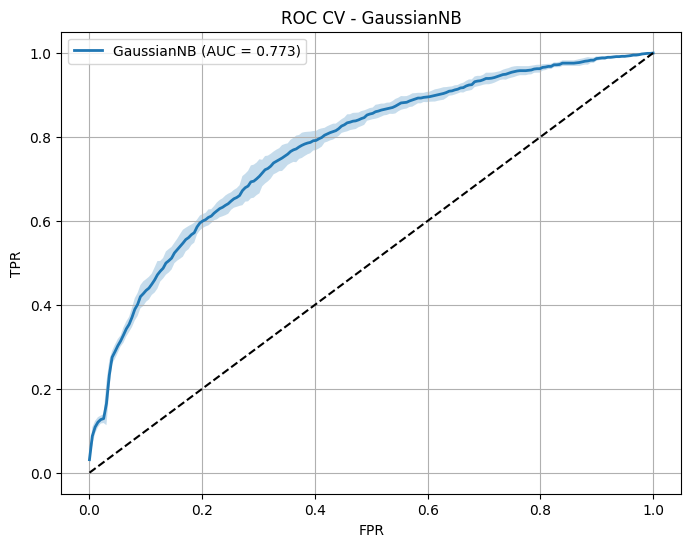


Classification Report - GaussianNB
              precision    recall  f1-score   support

           0       0.87      0.86      0.87      5113
           1       0.48      0.50      0.49      1287

    accuracy                           0.79      6400
   macro avg       0.67      0.68      0.68      6400
weighted avg       0.79      0.79      0.79      6400

Confusion Matrix:
[[4405  708]
 [ 644  643]]


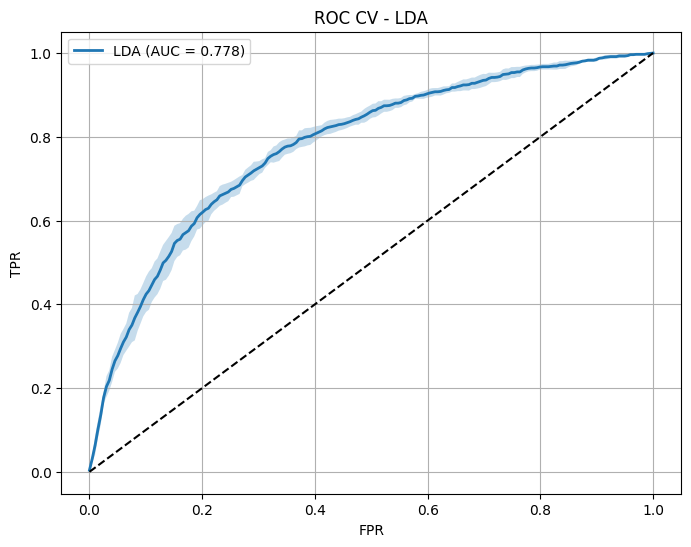


Classification Report - LDA
              precision    recall  f1-score   support

           0       0.83      0.96      0.89      5113
           1       0.60      0.23      0.34      1287

    accuracy                           0.81      6400
   macro avg       0.72      0.60      0.61      6400
weighted avg       0.79      0.81      0.78      6400

Confusion Matrix:
[[4917  196]
 [ 988  299]]


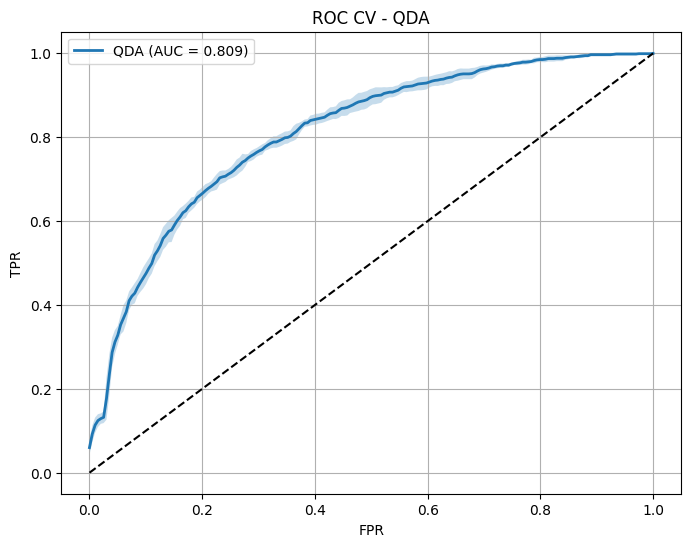


Classification Report - QDA
              precision    recall  f1-score   support

           0       0.84      0.96      0.90      5113
           1       0.63      0.30      0.41      1287

    accuracy                           0.82      6400
   macro avg       0.74      0.63      0.65      6400
weighted avg       0.80      0.82      0.80      6400

Confusion Matrix:
[[4889  224]
 [ 898  389]]


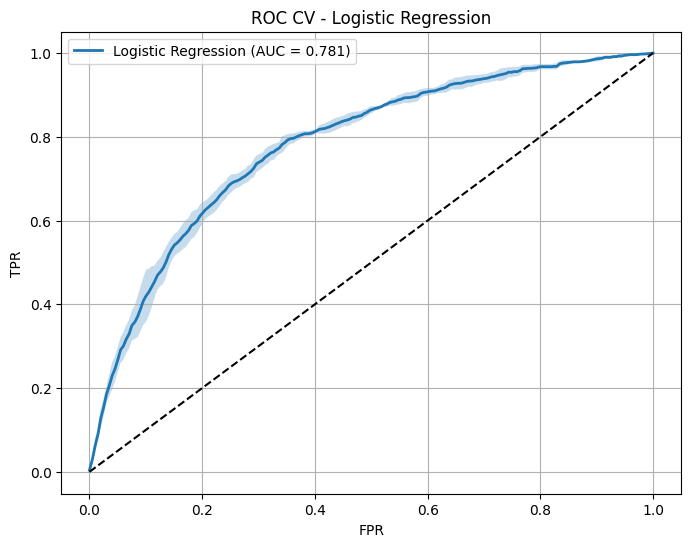


Classification Report - Logistic Regression
              precision    recall  f1-score   support

           0       0.91      0.73      0.81      5113
           1       0.40      0.70      0.51      1287

    accuracy                           0.73      6400
   macro avg       0.65      0.72      0.66      6400
weighted avg       0.80      0.73      0.75      6400

Confusion Matrix:
[[3748 1365]
 [ 389  898]]


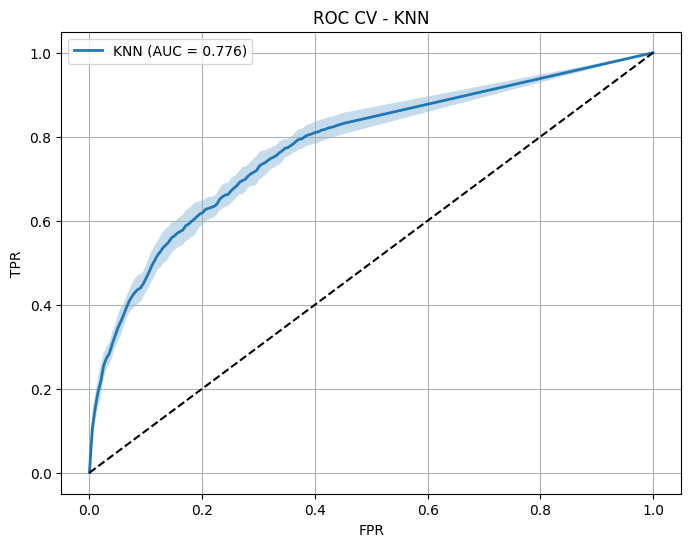


Classification Report - KNN
              precision    recall  f1-score   support

           0       0.86      0.94      0.90      5113
           1       0.61      0.38      0.47      1287

    accuracy                           0.83      6400
   macro avg       0.73      0.66      0.68      6400
weighted avg       0.81      0.83      0.81      6400

Confusion Matrix:
[[4793  320]
 [ 794  493]]


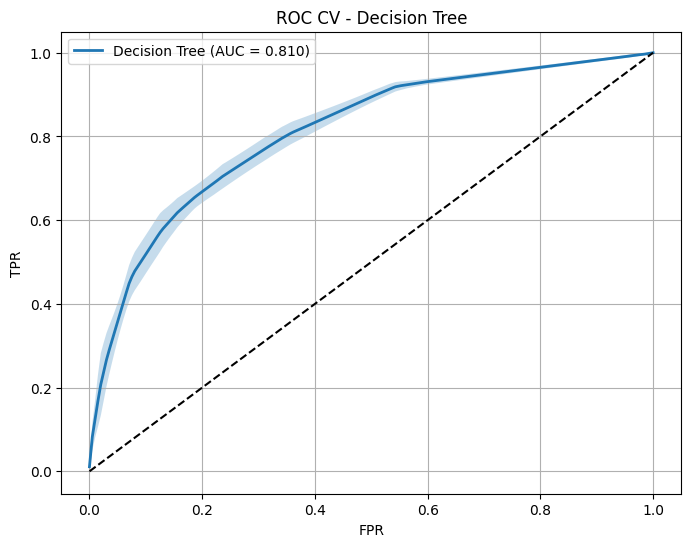


Classification Report - Decision Tree
              precision    recall  f1-score   support

           0       0.92      0.72      0.81      5113
           1       0.40      0.75      0.52      1287

    accuracy                           0.73      6400
   macro avg       0.66      0.73      0.67      6400
weighted avg       0.82      0.73      0.75      6400

Confusion Matrix:
[[3678 1435]
 [ 322  965]]


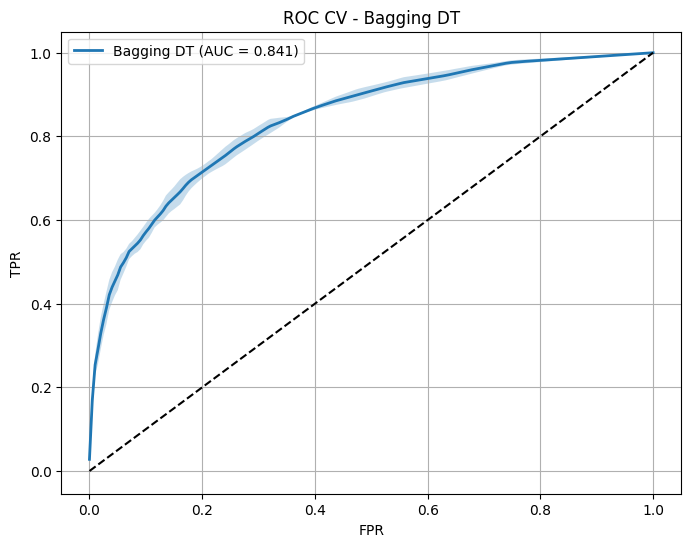


Classification Report - Bagging DT
              precision    recall  f1-score   support

           0       0.87      0.96      0.91      5113
           1       0.74      0.43      0.54      1287

    accuracy                           0.86      6400
   macro avg       0.81      0.70      0.73      6400
weighted avg       0.84      0.86      0.84      6400

Confusion Matrix:
[[4918  195]
 [ 732  555]]


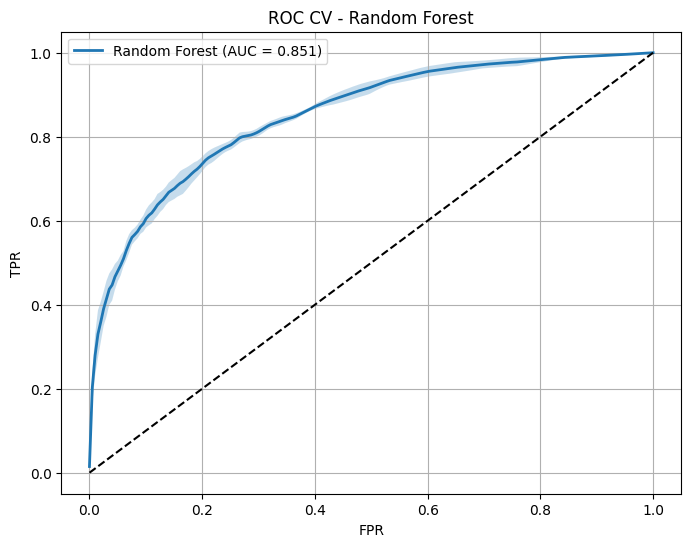


Classification Report - Random Forest
              precision    recall  f1-score   support

           0       0.87      0.97      0.92      5113
           1       0.77      0.43      0.55      1287

    accuracy                           0.86      6400
   macro avg       0.82      0.70      0.73      6400
weighted avg       0.85      0.86      0.84      6400

Confusion Matrix:
[[4949  164]
 [ 734  553]]


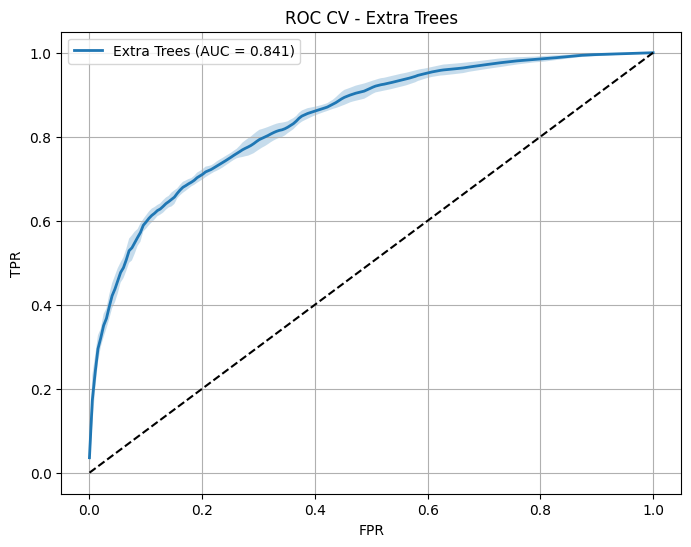


Classification Report - Extra Trees
              precision    recall  f1-score   support

           0       0.87      0.96      0.91      5113
           1       0.73      0.42      0.53      1287

    accuracy                           0.85      6400
   macro avg       0.80      0.69      0.72      6400
weighted avg       0.84      0.85      0.84      6400

Confusion Matrix:
[[4913  200]
 [ 748  539]]


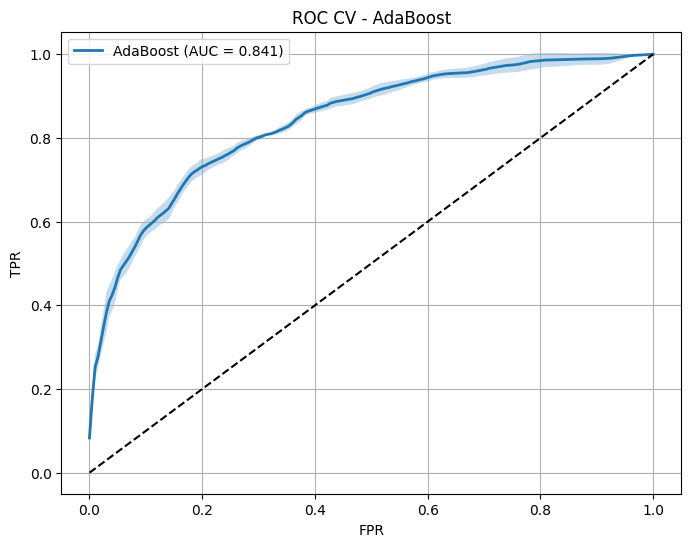


Classification Report - AdaBoost
              precision    recall  f1-score   support

           0       0.92      0.80      0.86      5113
           1       0.48      0.73      0.58      1287

    accuracy                           0.79      6400
   macro avg       0.70      0.76      0.72      6400
weighted avg       0.83      0.79      0.80      6400

Confusion Matrix:
[[4102 1011]
 [ 351  936]]


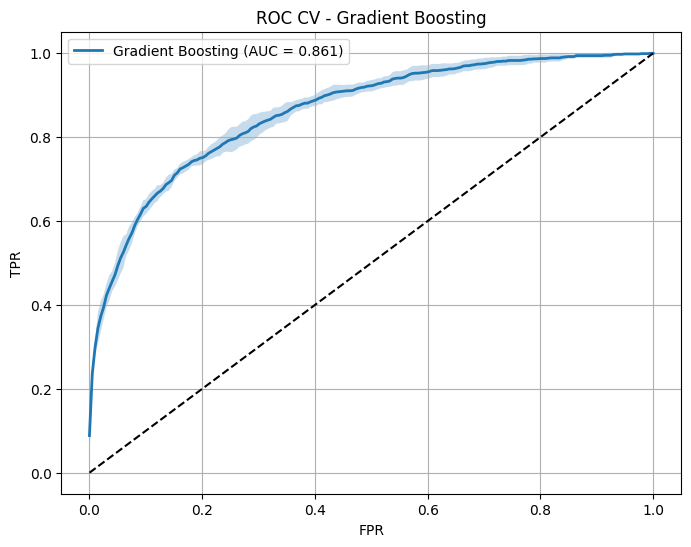


Classification Report - Gradient Boosting
              precision    recall  f1-score   support

           0       0.92      0.82      0.87      5113
           1       0.51      0.73      0.60      1287

    accuracy                           0.80      6400
   macro avg       0.72      0.78      0.73      6400
weighted avg       0.84      0.80      0.81      6400

Confusion Matrix:
[[4189  924]
 [ 342  945]]


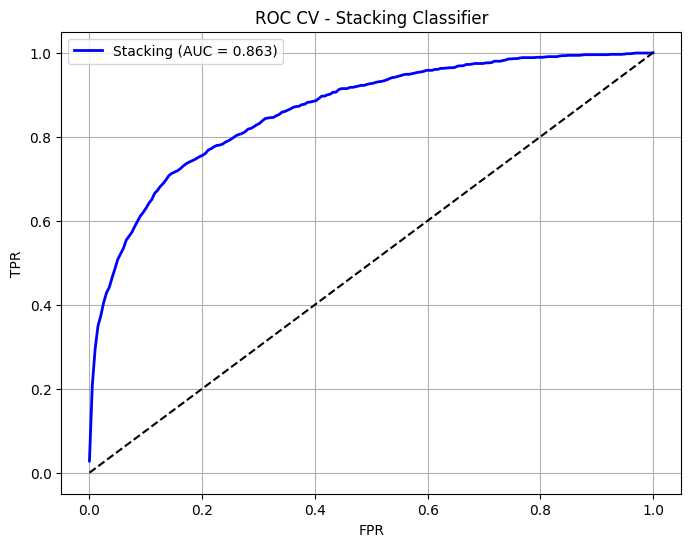


Classification Report - Stacking
Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.91      0.90      5113
           1       0.63      0.57      0.59      1287

    accuracy                           0.84      6400
   macro avg       0.76      0.74      0.75      6400
weighted avg       0.84      0.84      0.84      6400

Confusion Matrix:
[[4676  437]
 [ 558  729]]

=== Performance with anomaly features ===
                  Model  CV-Accuracy  CV-Precision  CV-Recall     CV-F1  \
11             Stacking     0.844844      0.618167   0.597514  0.607665   
10    Gradient Boosting     0.801406      0.504879   0.731961  0.597197   
7         Random Forest     0.858906      0.775456   0.421196  0.544831   
9              AdaBoost     0.789687      0.485334   0.725732  0.581443   
8           Extra Trees     0.854219      0.746511   0.417290  0.534561   
6            Bagging DT     0.854375      0.737695   0.429717  0.542323   
2  

In [10]:
models_anom = {
    "GaussianNB": (GaussianNB(), "scaled"),
    "LDA": (LinearDiscriminantAnalysis(n_components=1), "scaled"),
    "QDA": (QuadraticDiscriminantAnalysis(), "scaled"),
    "Logistic Regression": (LogisticRegression(class_weight="balanced"), "scaled"),
    "KNN": (KNeighborsClassifier(n_neighbors=5, weights="distance"), "scaled"),
    "Decision Tree": (DecisionTreeClassifier(
        criterion="gini", max_depth=20, max_leaf_nodes=10,
        class_weight="balanced", random_state=42
    ), "raw"),
    "Bagging DT": (BaggingClassifier(
        estimator=DecisionTreeClassifier(criterion="gini", class_weight="balanced", random_state=42),
        n_estimators=50, random_state=42
    ), "raw"),
    "Random Forest": (RandomForestClassifier(class_weight="balanced", random_state=42), "raw"),
    "Extra Trees": (ExtraTreesClassifier(class_weight="balanced", random_state=42), "raw"),
    "AdaBoost": (AdaBoostClassifier(n_estimators=100, random_state=42), "raw"),
    "Gradient Boosting": (GradientBoostingClassifier(n_estimators=100, random_state=42), "raw")
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

def compute_cv(model, X, y):
    accs, precs, recs, f1s, aucs = [], [], [], [], []
    mean_fpr = np.linspace(0, 1, 200)
    tprs = []
    oof_preds = np.zeros(len(y))

    for train_idx, val_idx in cv.split(X, y):
        X_tr = X[train_idx] if isinstance(X, np.ndarray) else X.iloc[train_idx]
        X_val = X[val_idx] if isinstance(X, np.ndarray) else X.iloc[val_idx]
        y_tr = y[train_idx] if isinstance(y, np.ndarray) else y.iloc[train_idx]
        y_val = y[val_idx] if isinstance(y, np.ndarray) else y.iloc[val_idx]

        sw_tr = None
        if "sample_weight" in globals():
            sw = sample_weight
            sw_tr = sw[train_idx] if isinstance(sw, np.ndarray) else sw.iloc[train_idx]

        if isinstance(model, (GaussianNB, AdaBoostClassifier, GradientBoostingClassifier)):
            model.fit(X_tr, y_tr, sample_weight=sw_tr) if sw_tr is not None else model.fit(X_tr, y_tr)
        else:
            model.fit(X_tr, y_tr)

        y_pred_val = model.predict(X_val)
        y_prob_val = model.predict_proba(X_val)[:, 1]

        accs.append(accuracy_score(y_val, y_pred_val))
        precs.append(precision_score(y_val, y_pred_val))
        recs.append(recall_score(y_val, y_pred_val))
        f1s.append(f1_score(y_val, y_pred_val))
        aucs.append(roc_auc_score(y_val, y_prob_val))

        oof_preds[val_idx] = y_pred_val

        fpr, tpr, _ = roc_curve(y_val, y_prob_val)
        tpr_interp = np.interp(mean_fpr, fpr, tpr)
        tprs.append(tpr_interp)

    tprs = np.array(tprs)
    mean_tpr = tprs.mean(axis=0)
    std_tpr = tprs.std(axis=0)

    return {
        "acc": np.mean(accs),
        "prec": np.mean(precs),
        "rec": np.mean(recs),
        "f1": np.mean(f1s),
        "auc": np.mean(aucs),
        "mean_fpr": mean_fpr,
        "mean_tpr": mean_tpr,
        "std_tpr": std_tpr,
        "oof_preds": oof_preds
    }

results_anom = []

for name, (model, dtype) in models_anom.items():
    X_input = X_train_anom_scaled if dtype == "scaled" else X_train_anom
    res = compute_cv(model, X_input, y_train_anom)

    plt.figure(figsize=(8,6))
    plt.plot(res["mean_fpr"], res["mean_tpr"], linewidth=2, label=f"{name} (AUC = {res['auc']:.3f})")
    plt.fill_between(res["mean_fpr"], res["mean_tpr"] - res["std_tpr"], res["mean_tpr"] + res["std_tpr"], alpha=0.25)
    plt.plot([0,1],[0,1],"k--")
    plt.title("ROC CV - " + name)
    plt.xlabel("FPR")
    plt.ylabel("TPR")
    plt.legend()
    plt.grid()
    plt.show()

    print(f"\nClassification Report - {name}")
    print(classification_report(y_train_anom, res["oof_preds"]))
    print("Confusion Matrix:")
    print(confusion_matrix(y_train_anom, res["oof_preds"]))

    X_test_input = X_test_anom_scaled if dtype == "scaled" else X_test_anom
    sw_tr = sample_weight if "sample_weight" in globals() else None
    if isinstance(model, (GaussianNB, AdaBoostClassifier, GradientBoostingClassifier)):
        model.fit(X_input, y_train_anom, sample_weight=sw_tr) if sw_tr is not None else model.fit(X_input, y_train_anom)
    else:
        model.fit(X_input, y_train_anom)
    y_pred_test = model.predict(X_test_input)
    y_prob_test = model.predict_proba(X_test_input)[:, 1]

    results_anom.append([
        name,
        res["acc"],
        res["prec"],
        res["rec"],
        res["f1"],
        res["auc"],
        accuracy_score(y_test_anom, y_pred_test),
        precision_score(y_test_anom, y_pred_test),
        recall_score(y_test_anom, y_pred_test),
        f1_score(y_test_anom, y_pred_test),
        roc_auc_score(y_test_anom, y_prob_test)
    ])



estimators = [
    ("lr", LogisticRegression(class_weight="balanced"), "scaled"),
    ("rf", RandomForestClassifier(class_weight="balanced", random_state=42), "raw"),
    ("gb", GradientBoostingClassifier(n_estimators=100, random_state=42), "raw"),
    ("nb", GaussianNB(), "scaled"),
    ("et", ExtraTreesClassifier(class_weight="balanced", random_state=42), "raw")
]

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
meta_train = np.zeros((X_train_anom.shape[0], len(estimators)))
meta_test = np.zeros((X_test_anom.shape[0], len(estimators)))
oof_preds_total = np.zeros(X_train_anom.shape[0])

tprs = []
mean_fpr = np.linspace(0, 1, 200)

for i, (name, model, dtype) in enumerate(estimators):
    X_input = X_train_anom_scaled if dtype == "scaled" else X_train_anom
    test_input = X_test_anom_scaled if dtype == "scaled" else X_test_anom
    
    oof_preds = np.zeros(X_input.shape[0])
    test_preds_folds = np.zeros((X_test_anom.shape[0], cv.n_splits))
    
    for fold_idx, (train_idx, val_idx) in enumerate(cv.split(X_input, y_train_anom)):
        if isinstance(X_input, np.ndarray):
            X_tr, X_val = X_input[train_idx], X_input[val_idx]
        else:
            X_tr, X_val = X_input.iloc[train_idx], X_input.iloc[val_idx]
        
        if isinstance(y_train_anom, np.ndarray):
            y_tr, y_val = y_train[train_idx], y_train[val_idx]
        else:
            y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]

        sw_tr = None
        if "sample_weight" in globals() and isinstance(model, (GaussianNB, AdaBoostClassifier, GradientBoostingClassifier)):
            sw_tr = sample_weight[train_idx] if isinstance(sample_weight, np.ndarray) else sample_weight.iloc[train_idx]

        if sw_tr is not None:
            model.fit(X_tr, y_tr, sample_weight=sw_tr)
        else:
            model.fit(X_tr, y_tr)
        
        oof_preds[val_idx] = model.predict_proba(X_val)[:, 1]
        test_preds_folds[:, fold_idx] = model.predict_proba(test_input)[:, 1]
    
    meta_train[:, i] = oof_preds
    meta_test[:, i] = test_preds_folds.mean(axis=1)
    oof_preds_total += oof_preds 

final_est = LogisticRegression(class_weight="balanced", max_iter=1000)
final_est.fit(meta_train, y_train_anom)

y_pred_cv_stack = (meta_train.mean(axis=1) > 0.5).astype(int)
y_prob_cv_stack = final_est.predict_proba(meta_train)[:, 1]

acc_cv = accuracy_score(y_train_anom, y_pred_cv_stack)
prec_cv = precision_score(y_train_anom, y_pred_cv_stack)
rec_cv = recall_score(y_train_anom, y_pred_cv_stack)
f1_cv = f1_score(y_train_anom, y_pred_cv_stack)
roc_auc_cv = roc_auc_score(y_train_anom, y_prob_cv_stack)

fpr, tpr, _ = roc_curve(y_train_anom, y_prob_cv_stack)
tpr_interp = np.interp(mean_fpr, fpr, tpr)
tprs.append(tpr_interp)
mean_tpr = np.mean(tprs, axis=0)
std_tpr = np.std(tprs, axis=0)

plt.figure(figsize=(8,6))
plt.plot(mean_fpr, mean_tpr, linewidth=2, label=f"Stacking (AUC = {roc_auc_cv:.3f})", color="blue")
plt.fill_between(mean_fpr, mean_tpr - std_tpr, mean_tpr + std_tpr, alpha=0.25)
plt.plot([0,1],[0,1],"k--")
plt.title("ROC CV - Stacking Classifier")
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.legend()
plt.grid()
plt.show()

print("\nClassification Report - Stacking")
print("Classification Report:")
print(classification_report(y_train_anom, y_pred_cv_stack))
print("Confusion Matrix:")
print(confusion_matrix(y_train_anom, y_pred_cv_stack))

y_pred_test_stack = final_est.predict(meta_test)
y_prob_test_stack = final_est.predict_proba(meta_test)[:, 1]

acc_test = accuracy_score(y_test_anom, y_pred_test_stack)
prec_test = precision_score(y_test_anom, y_pred_test_stack)
rec_test = recall_score(y_test_anom, y_pred_test_stack)
f1_test = f1_score(y_test_anom, y_pred_test_stack)
roc_auc_test = roc_auc_score(y_test_anom, y_prob_test_stack)

results_anom.append([
    "Stacking",
    acc_cv, prec_cv, rec_cv, f1_cv, roc_auc_cv,
    acc_test, prec_test, rec_test, f1_test, roc_auc_test
])



summary_df_anom = pd.DataFrame(
    results,
    columns=[
        "Model","CV-Accuracy","CV-Precision","CV-Recall","CV-F1","CV-ROC-AUC",
        "Test-Accuracy","Test-Precision","Test-Recall","Test-F1","Test-ROC-AUC"
    ]
)

print("\n=== Performance with anomaly features ===")
print(summary_df_anom.sort_values("Test-ROC-AUC", ascending=False))



try:
    comparison_df = summary_df.merge(
        summary_df_anom, on="Model", suffixes=("_base", "_anom")
    )
    print("\n=== Comparison base vs with anomalies ===")
    print(comparison_df)
except NameError:
    print(
        "summary_df (base) is not defined in this kernel: run the cell that calculates it first."
    )

FAIRNESS ANALYSIS

In [11]:
df_fairness = X_test.copy()
df_fairness['y_true'] = y_test

gbc, dtype = models["Gradient Boosting"]
X_input = X_test if dtype=="raw" else X_test_scaled
df_fairness['y_pred'] = gbc.predict(X_input)

gender_map = {0: 'Female', 1: 'Male'}
df_fairness['Gender_Label'] = df_fairness['Gender'].map(gender_map)

mask_female = df_fairness['Gender'] == 0
mask_male = df_fairness['Gender'] == 1

print(f"Total samples in test set: {len(df_fairness)}")
print(f"Samples Female: {mask_female.sum()}")
print(f"Samples Male:   {mask_male.sum()}\n")

# INDEPENDENCE
prob_pred_churn_female = df_fairness.loc[mask_female, 'y_pred'].mean()
prob_pred_churn_male = df_fairness.loc[mask_male, 'y_pred'].mean()

print("--- INDEPENDENCE ---")
print(f"Probability of predicting Churn (Female): {prob_pred_churn_female:.4f}")
print(f"Probability of predicting Churn (Male):   {prob_pred_churn_male:.4f}")
print(f"Gap (Female - Male): {prob_pred_churn_female - prob_pred_churn_male:.4f}")
if abs(prob_pred_churn_female - prob_pred_churn_male) > 0.1:
    print(">> Possible violation of Independence.")
else:
    print(">> Independencerespected.")

# SEPARATION
# female metrics
tn_f, fp_f, fn_f, tp_f = confusion_matrix(df_fairness.loc[mask_female, 'y_true'], 
                                          df_fairness.loc[mask_female, 'y_pred'], labels=[0,1]).ravel()
tpr_female = tp_f / (tp_f + fn_f) if (tp_f + fn_f) > 0 else 0
fpr_female = fp_f / (fp_f + tn_f) if (fp_f + tn_f) > 0 else 0

# male metrics
tn_m, fp_m, fn_m, tp_m = confusion_matrix(df_fairness.loc[mask_male, 'y_true'], 
                                          df_fairness.loc[mask_male, 'y_pred'], labels=[0,1]).ravel()
tpr_male = tp_m / (tp_m + fn_m) if (tp_m + fn_m) > 0 else 0
fpr_male = fp_m / (fp_m + tn_m) if (fp_m + tn_m) > 0 else 0

print("\n\n--- SEPARATION ---")
print(f"True Positive Rate (TPR) Female: {tpr_female:.4f}")
print(f"True Positive Rate (TPR) Male:   {tpr_male:.4f}")
print(f"Diff TPR: {tpr_female - tpr_male:.4f}")
print(f"\nFalse Positive Rate (FPR) Female: {fpr_female:.4f}")
print(f"False Positive Rate (FPR) Male:   {fpr_male:.4f}")
print(f"Diff FPR: {fpr_female - fpr_male:.4f}")

# SUFFICIENCY
ppv_female = precision_score(df_fairness.loc[mask_female, 'y_true'], 
                             df_fairness.loc[mask_female, 'y_pred'], zero_division=0)
ppv_male = precision_score(df_fairness.loc[mask_male, 'y_true'], 
                           df_fairness.loc[mask_male, 'y_pred'], zero_division=0)

print("\n\n--- SUFFICIENCY ---")
print(f"Precision (PPV) Female: {ppv_female:.4f}")
print(f"Precision (PPV) Male:   {ppv_male:.4f}")
print(f"Diff PPV: {ppv_female - ppv_male:.4f}")

if abs(ppv_female - ppv_male) > 0.1:
    print(">> Model confidence varies significantly between genders.")
else:
    print(">> Sufficiency respected.")

Total samples in test set: 1600
Samples Female: 733
Samples Male:   867

--- INDEPENDENCE ---
Probability of predicting Churn (Female): 0.3724
Probability of predicting Churn (Male):   0.2284
Gap (Female - Male): 0.1441
>> Possible violation of Independence.


--- SEPARATION ---
True Positive Rate (TPR) Female: 0.7594
True Positive Rate (TPR) Male:   0.7333
Diff TPR: 0.0260

False Positive Rate (FPR) Female: 0.2399
False Positive Rate (FPR) Male:   0.1352
Diff FPR: 0.1047


--- SUFFICIENCY ---
Precision (PPV) Female: 0.5201
Precision (PPV) Male:   0.5000
Diff PPV: 0.0201
>> Sufficiency respected.
